In [1]:
!pip install tensorflow_addons==0.9.1

     |████████████████████████████████| 1.0 MB 8.5 MB/s 


In [2]:
from tensorflow.keras.layers import (TimeDistributed, Dropout, BatchNormalization, Flatten, Convolution1D, Activation, Input, Dense, LSTM, Lambda, Bidirectional,
                                     Add, AveragePooling1D, Multiply, GRU, GRUCell, LSTMCell, SimpleRNNCell, SimpleRNN, TimeDistributed, RNN,
                                     RepeatVector, Conv1D, MaxPooling1D, Concatenate, GlobalAveragePooling1D, UpSampling1D)
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, mean_squared_error
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras import backend as K
import tensorflow as tf
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error, f1_score, confusion_matrix, recall_score,precision_score,log_loss
from logging import getLogger, Formatter, StreamHandler, FileHandler, INFO
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from tqdm import tqdm_notebook as tqdm
from contextlib import contextmanager
from joblib import Parallel, delayed
from IPython.display import display
from sklearn import preprocessing
import tensorflow_addons as tfa
import scipy.stats as stats
import random as rn
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import warnings
import time
import pywt
import os
import gc
from datetime import datetime
import matplotlib.pylab as plt
import seaborn as sns
import random
from typing import Tuple

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [3]:
def plot_cm(y_true, y_pred, title):
    figsize=(14,14)
    y_pred = y_pred.astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)


def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def lr_schedule(epoch):
    if epoch < 40:
        lr = LR
    elif epoch < 20:
        lr = LR / 10
    else:
        lr = LR / 100
    return lr

def augment(X, y):
    
    X = np.vstack((X, np.flip(X, axis=1))) 
    y = np.vstack((y, np.flip(y, axis=1)))
    
    return X, y

In [4]:
def Classifier(shape_):
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    
    x = wave_block(inp, 16, 3, 8)
    x = wave_block(x, 32, 3, 12)
    x = wave_block(x, 64, 3, 4)
    x = wave_block(x, 128, 3, 1)
    #x = Bidirectional(CuDNNGRU(128,return_sequences=True))(x)

    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)

    model.compile(loss = losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])

    return model

# Class to return F1 Macro at the end of each epoch
# It also enables us to apply early stopping on F1 Macro
class Metric(Callback):
    def __init__(self, model, callbacks, data):
        super().__init__()
        self.model = model
        self.callbacks = callbacks
        self.data = data

    def on_train_begin(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_end(logs)

    def on_epoch_end(self, batch, logs=None):
        X_valid, y_valid = self.data[1][0], self.data[1][1]
        y_valid = np.argmax(y_valid, axis=2).reshape(-1)
        valid_pred = np.argmax(self.model.predict(X_valid), axis=2).reshape(-1)
        valid_recall = recall_score(y_valid, valid_pred, average="macro")        
        valid_precision = precision_score(y_valid, valid_pred, average="macro")        
        valid_score = f1_score(y_valid, valid_pred, average="macro")        
        logs['Valid_F1Macro'] = valid_score
        logs['Valid_Recall'] = valid_recall
        logs['Valid_Precision'] = valid_precision

        print(f"Validation F1 Macro {valid_score:1.6f} Validation Recall {valid_recall:1.6f} Validation Precision {valid_precision:1.6f}")
        # print(' Train F1 Macro', train_score, 'Validation F1 Macro', valid_score)

        for callback in self.callbacks:
            callback.on_epoch_end(batch, logs)
        
        gc.collect()            

## Step by Step

In [5]:
# configurations and main hyperparammeters
EPOCHS = 70
NNBATCHSIZE = 16
GROUP_BATCH_SIZE = 4000
SEED = 321
LR = 0.001
SPLITS = 5
SLIDE = 800
seed_everything(SEED)

In [6]:
# Load Data
train = pd.read_csv("/kaggle/input/remove-trends-giba/train_clean_giba.csv", usecols=["signal","open_channels"], dtype={'signal': np.float32, 'open_channels':np.int32})
test  = pd.read_csv("/kaggle/input/remove-trends-giba/test_clean_giba.csv", usecols=["signal"], dtype={'signal': np.float32})

# 5+8 Augmentation to Create new batch with 10 channels
train['group'] = np.arange(train.shape[0])//500_000
aug_df = train[train["group"] == 5].copy()
aug_df["group"] = 10

for col in ["signal", "open_channels"]:
    aug_df[col] += train[train["group"] == 8][col].values

train = train.append(aug_df, sort=False).reset_index(drop=True)
del aug_df
gc.collect()

35

In [7]:
# Load OOFs for stacking
train["mlp"] = np.load("/kaggle/input/into-the-wild-mlp-regression/mlp_reg.npz")['valid']  
test["mlp"] = np.load("/kaggle/input/into-the-wild-mlp-regression/mlp_reg.npz")['test']  

train["lgb"] = np.load("/kaggle/input/into-the-wild-lgb-regression/lgb_reg.npz")['valid']  
test["lgb"] = np.load("/kaggle/input/into-the-wild-lgb-regression/lgb_reg.npz")['test']  

Y_train_proba = np.load("/kaggle/input/into-the-wild-rfc-classification/rfc_clf.npz")["valid"]
Y_test_proba = np.load("/kaggle/input/into-the-wild-rfc-classification/rfc_clf.npz")["test"]

for i in range(11):
    train[f"rfc_{i}"] = Y_train_proba[:, i]
    test[f"rfc_{i}"] = Y_test_proba[:, i]

del Y_train_proba, Y_test_proba
gc.collect()

0

In [8]:
# Standart Scaling
for item in ['signal','mlp','lgb']:
    if item in train.columns:
        print(item)
        train_input_mean = train[item].mean()
        train_input_sigma = train[item].std()
        train[item]= (train[item] - train_input_mean) / train_input_sigma
        test[item] = (test[item] - train_input_mean) / train_input_sigma
    
# Batching for train and test
train['batch'] = train.groupby(train.index//GROUP_BATCH_SIZE, sort=False)['signal'].agg(['ngroup']).values
train['batch'] = train['batch'].astype(np.uint16)

test['batch'] = test.groupby(test.index//100_000, sort=False)['signal'].agg(['ngroup']).values
test['batch'] = test['batch'].astype(np.uint16)

# Fill NAs and Select Features
feats = [col for col in train.columns if col not in ['index','batch', 'open_channels', 'time', 'group']]
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

for col in feats:
    col_mean = pd.concat([train[col], test[col]], axis=0).mean()
    train[col] = train[col].fillna(col_mean)
    test[col] = test[col].fillna(col_mean)

print(feats)

signal
mlp
lgb
['signal', 'mlp', 'lgb', 'rfc_0', 'rfc_1', 'rfc_2', 'rfc_3', 'rfc_4', 'rfc_5', 'rfc_6', 'rfc_7', 'rfc_8', 'rfc_9', 'rfc_10']


### Model Training

In [9]:
def run_cv_model_by_batch(train, test, n_splits, feats, nn_epochs, nn_batch_size):
    seed_everything(SEED)
    K.clear_session()
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
    tf.compat.v1.keras.backend.set_session(sess)
    oof_ = np.zeros((len(train), 11))
    oof_tta = np.zeros((len(train), 11))
    preds_ = np.zeros((len(test), 11))
    target = ['open_channels']
    
    group = train['batch']
    kf = GroupKFold(n_splits=5)
    splits = [x for x in kf.split(train, train[target], group)]

    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[1])    
        new_splits.append(new_split)

    # pivot target columns to transform the net to a multiclass classification estructure (you can also leave it in 1 vector with sparsecategoricalcrossentropy loss function)
    tr = pd.concat([pd.get_dummies(train.open_channels), train[['batch']]], axis=1)
    tr.columns = ['target_'+str(i) for i in range(11)] + ['batch']
    target_cols = ['target_'+str(i) for i in range(11)]
    train_tr = np.array(list(tr.groupby('batch').apply(lambda x: x[target_cols].values))).astype(np.float32)

    del tr, group
    gc.collect()
    
    train = np.array(list(train.groupby('batch').apply(lambda x: x[feats].values)))
    test = np.array(list(test.groupby('batch').apply(lambda x: x[feats].values)))
    test_flip = np.flip(test, axis=1)
    
    for n_fold, (tr_idx, val_idx, val_orig_idx) in enumerate(new_splits[0:], start=0):
        print("="*11,f'Training Started for Fold {n_fold+1}',"="*11,"\n")
        train_x, train_y = train[tr_idx], train_tr[tr_idx]
        valid_x, valid_y = train[val_idx], train_tr[val_idx]
        
        train_x, train_y = augment(train_x, train_y)
        
        gc.collect()
                
        valid_x_flip = np.flip(valid_x, axis=1)

        shape_ = (None, train_x.shape[2])
        model = Classifier(shape_)

        cp = ModelCheckpoint(f"model_fold{n_fold+1}.h5", monitor='Valid_F1Macro', mode='max',save_best_only=True, verbose=1, period=1)
        cp.set_model(model)
        #es = EarlyStopping(monitor='Valid_F1Macro',mode='min',restore_best_weights=True,verbose=1,patience=21)
        #es.set_model(model)

        cb_lr_schedule = LearningRateScheduler(lr_schedule)               
        metric = Metric(model, [cp], [(train_x, train_y), (valid_x, valid_y)]) # ,es
        
        model.fit(train_x, train_y,epochs = nn_epochs,
                  callbacks = [cb_lr_schedule, metric], # MacroF1(model, [valid_x_sig, valid_x_oof], valid_y)
                  batch_size = nn_batch_size, verbose = 0,
                  validation_data = (valid_x, valid_y))
        
        model.load_weights(f"model_fold{n_fold+1}.h5")
        preds_f = model.predict(valid_x)
        preds_f_tta = np.flip(model.predict(valid_x_flip), axis=1)

        f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f, axis=2).reshape(-1), average = 'macro')
        print(f'Training fold {n_fold + 1} completed. F1 Macro : {f1_score_ :1.5f}')
        f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f + preds_f_tta, axis=2).reshape(-1), average = 'macro')
        print(f'Training fold {n_fold + 1} completed. F1 Macro with TTA : {f1_score_ :1.5f}','\n')
        
        oof_[val_orig_idx,:] += preds_f.reshape(-1, preds_f.shape[-1])
        oof_tta[val_orig_idx,:] += preds_f_tta.reshape(-1, preds_f.shape[-1])
        
        def sliding_predict(model, x):
            pred = np.zeros((x.shape[0], 100_000, 11))
            for begin in range(0, 100_000, SLIDE):
                end = begin + GROUP_BATCH_SIZE
                pred[:, begin:end, :] += model.predict(x[:, begin:end, :])
            return pred
        
        te_preds = sliding_predict(model, test)
        te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
        preds_ += te_preds
        
        te_preds = np.flip(sliding_predict(model, test_flip), axis=1)
        te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
        preds_ += te_preds

    # calculate the oof macro f1_score
    f1_score_ = f1_score(np.argmax(train_tr, axis = 2).reshape(-1),  np.argmax(oof_, axis = 1), average = 'macro') # axis 2 for the 3 Dimension array and axis 1 for the 2 Domension Array (extracting the best class)
    print(f'Training completed. OOF F1 Macro : {f1_score_:1.5f}')
    f1_score_ = f1_score(np.argmax(train_tr, axis = 2).reshape(-1),  np.argmax(oof_ + oof_tta, axis = 1), average = 'macro') # axis 2 for the 3 Dimension array and axis 1 for the 2 Domension Array (extracting the best class)
    print(f'Training completed. OOF F1 Macro with TTA : {f1_score_:1.5f}')
    return preds_, oof_, oof_tta

In [10]:
preds, oof, oof_tta = run_cv_model_by_batch(train, test, n_splits=5, feats=feats, nn_epochs=EPOCHS, nn_batch_size=NNBATCHSIZE)

=========== Training Started for Fold 1 =========== 

Validation F1 Macro 0.939204 Validation Recall 0.937270 Validation Precision 0.941323

Epoch 00001: Valid_F1Macro improved from -inf to 0.93920, saving model to model_fold1.h5
Validation F1 Macro 0.940215 Validation Recall 0.939013 Validation Precision 0.941474

Epoch 00002: Valid_F1Macro improved from 0.93920 to 0.94022, saving model to model_fold1.h5
Validation F1 Macro 0.940238 Validation Recall 0.940076 Validation Precision 0.940455

Epoch 00003: Valid_F1Macro improved from 0.94022 to 0.94024, saving model to model_fold1.h5
Validation F1 Macro 0.939156 Validation Recall 0.940818 Validation Precision 0.937707

Epoch 00004: Valid_F1Macro did not improve from 0.94024
Validation F1 Macro 0.940209 Validation Recall 0.940536 Validation Precision 0.939915

Epoch 00005: Valid_F1Macro did not improve from 0.94024
Validation F1 Macro 0.937859 Validation Recall 0.934526 Validation Precision 0.942211

Epoch 00006: Valid_F1Macro did not impr

In [11]:
oof_df = train[['signal','open_channels']].copy()
oof_df["oof"] = np.argmax(oof+oof_tta, axis=1)
oof_df = oof_df.head(5000_000)
gc.collect()

oof_f1 = f1_score(oof_df['open_channels'],oof_df['oof'],average = 'macro')
oof_recall = recall_score(oof_df['open_channels'],oof_df['oof'],average = 'macro')
oof_precision = precision_score(oof_df['open_channels'],oof_df['oof'],average = 'macro')
oof_loss = log_loss(oof_df["open_channels"], (oof/2+oof_tta/2)[:5000_000])

print(f"OOF F1 Macro Score: {oof_f1:.6f} - OOF Recall Score: {oof_recall:.6f} - OOF Precision Score: {oof_precision:.6f}, OOF Log Loss Score: {oof_loss:.6f} ")

OOF F1 Macro Score: 0.943420 - OOF Recall Score: 0.941853 - OOF Precision Score: 0.945075, OOF Log Loss Score: 0.072523 


In [12]:
np.savez_compressed(f'wavenet.npz',valid=oof, test=preds,tta=oof_tta)

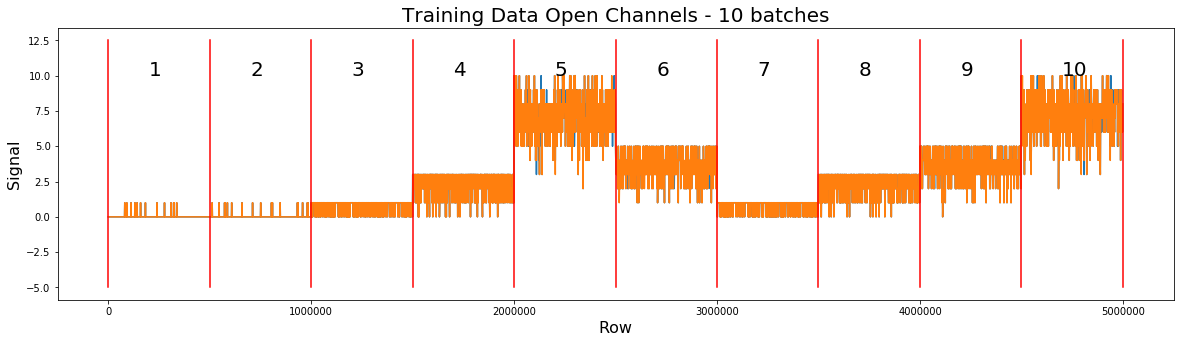

In [13]:
res = 1000 # Resolution of signal plots
num_batches = 10
batch_size = 500000

plt.figure(figsize=(20,5));
plt.plot(range(0,oof_df.shape[0],res),oof_df.open_channels[0::res])
plt.plot(range(0,oof_df.shape[0],res),oof_df.oof[0::res])
for i in range(num_batches+1): plt.plot([i*batch_size,i*batch_size],[-5,12.5],'r')
for j in range(num_batches): plt.text(j*batch_size+200000,num_batches,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Open Channels - 10 batches',size=20)
plt.show()

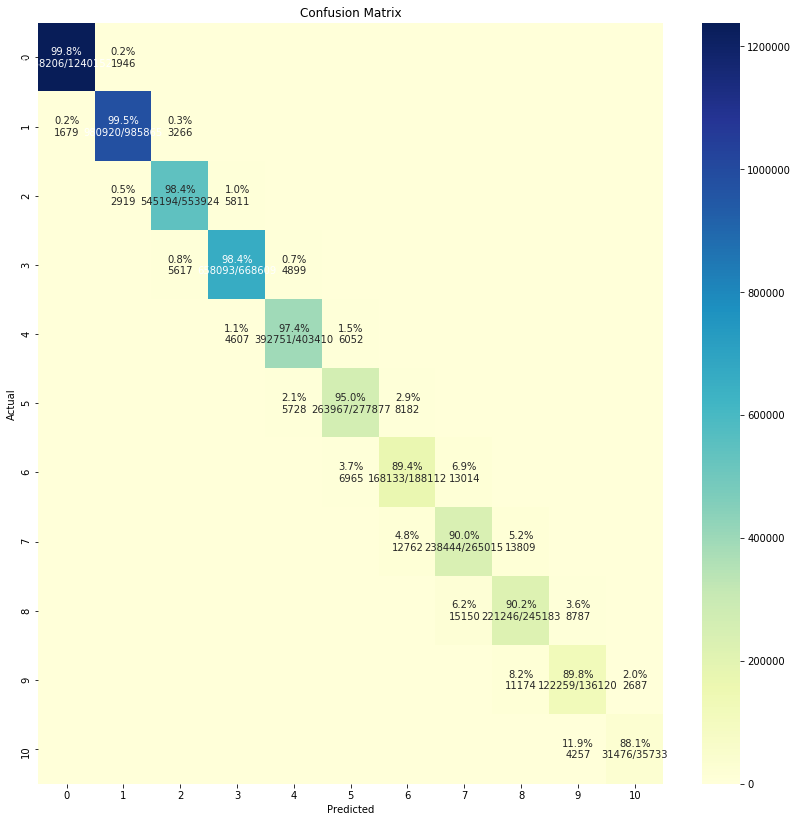

In [14]:
plot_cm(oof_df['open_channels'],oof_df['oof'],'Confusion Matrix')

## Submission

In [15]:
sample_submission  = pd.read_csv('/kaggle/input/liverpool-ion-switching/sample_submission.csv', dtype={'time': np.float32})
sample_submission['open_channels'] = np.argmax(preds, axis=1).astype(int)
sample_submission.to_csv(f'submission.csv', index=False, float_format='%.4f')
print(sample_submission.open_channels.mean())
display(sample_submission.head())

1.382338


,time,open_channels
0,500.000092,0
1,500.000214,0
2,500.000305,0
3,500.000397,0
4,500.000488,0


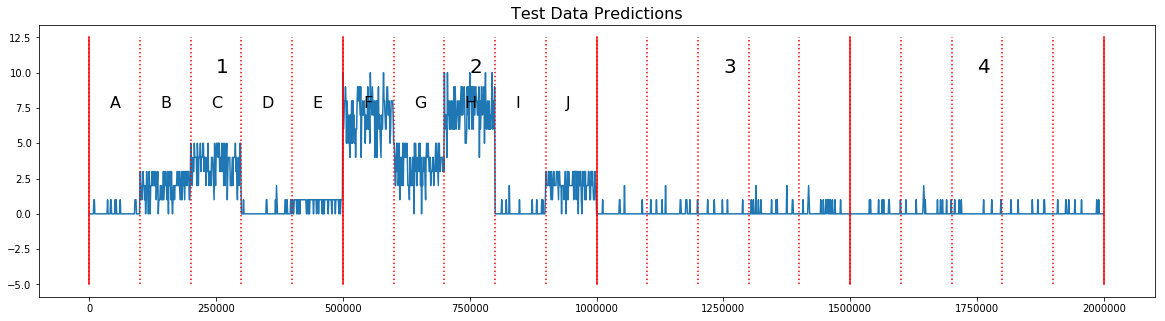

In [16]:
let = ['A','B','C','D','E','F','G','H','I','J']
res = 1000

plt.figure(figsize=(20,5))
plt.plot(range(0,sample_submission.shape[0],res),sample_submission.open_channels[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
plt.title('Test Data Predictions',size=16)
plt.show()